In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import sys
import kepler
import astropy.units as u
import astropy.constants as c
from scipy import (special, stats)
import pylab
import sys

from functions import  single_probability,plot_utils, simulate
G =c.G.to(u.au ** 3 / u.M_sun / u.day ** 2).value
observing_span = 668

In [2]:
sns.set_style("ticks")
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['font.family'] = "serif"
plt.rcParams["errorbar.capsize"] = 20



params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}


plt.rcParams['mathtext.fontset'] = 'dejavuserif'

plt.rcParams.update(params)
plt.rc('font',**{'family':'serif','sans-serif':['Times']})

plt.rcParams['font.family'] = "serif"

In [4]:

sys.path.insert(0, "/home/quadry/binary_planet_host_project")
proc_kic = pd.read_csv('/home/quadry/binary_planet_host_project/data/bright_kic_data-xm-rc.0.csv')


In [15]:
def RadialVelocity1(m_1,q,e,i,a,phi,w,t,eps):
    m_2=m_1*q
   
    
    period = 2*np.pi*np.sqrt((a)**3/(G*(m_1+m_2)))
    n = 2*np.pi/period
    
    
    mean_anomaly = n*(t)+phi
    eccentric_anomaly, cos_true_anomaly, sin_true_anomaly = kepler.kepler(mean_anomaly, e)
    k = np.sqrt(G/(m_1+m_2)*a*(1-e**2))
    b = m_2*np.sin(np.deg2rad(i))*(np.cos(w) * cos_true_anomaly - np.sin(w) * sin_true_anomaly + e * np.cos(w))
    rv = k*b
    RV = (rv*(u.AU/u.day)).to(u.km/u.s).value
    #sigma = np.array(np.random.uniform(low=2, high=3,size=1), dtype=float)
    noisy_RV = RV+(eps*np.random.randn(*RV.shape))
    
    return noisy_RV,k

In [5]:

proc_kic = proc_kic [proc_kic ['radial_velocity_error'].notna()]

m_g = proc_kic['phot_rp_mean_mag']


proc_kic['r Mag']= M_g
proc_kic['converted_sigma_1'] = np.sqrt((2*proc_kic['radial_velocity_error']**2*proc_kic['rv_nb_transits']-0.0242*proc_kic['rv_nb_transits'])/np.pi)


/home/quadry/anaconda3/envs/isochrones/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
proc_kic['color bins'] = pd.cut(proc_kic['bp_rp'], 10)
proc_kic['mag bins'] = pd.cut(proc_kic['phot_rp_mean_mag'], 10)
proc_kic['M bins'] = pd.cut(proc_kic['r Mag'], 10)

proc_kic['color label'] = pd.cut(proc_kic['bp_rp'], 10, labels=False)
proc_kic['mag label'] = pd.cut(proc_kic['phot_rp_mean_mag'], 10, labels=False)
proc_kic['M label'] = pd.cut(proc_kic['r Mag'], 10, labels=False)

In [7]:
p = proc_kic[proc_kic['rv_p_single']>.9].dropna().groupby(['color bins', 'mag bins','M bins']).agg('mean')[['converted_sigma_1','radial_velocity_error'
                                                                                        ,"rv_gp_predict_theta",
                                                              "rv_gp_predict_mu_single","rv_gp_predict_sigma_single","rv_gp_predict_sigma_multiple",'color label','mag label','M label']]
p.unstack()
p = p.dropna()
p = p.reset_index(level=['M bins','color bins', 'mag bins'])
colors = []
for i in range(len(p)):
    colors.append(p['color bins'].loc[i].mid)
p['colors'] = colors

mags = []
for i in range(len(p)):
    mags.append(p['mag bins'].loc[i].mid)
p['mags'] = mags

In [38]:
#%%time

mag_bins = []
for i in p['mag label'].unique():
    mag_bins.append(p[p['mag label']==i].sample(n=100000, replace=True))
bin_info = pd.concat(mag_bins)
    
N = len(bin_info)    
#bin_info = p.sample(n=N, replace=True)
#eps= np.array([]) 
#for i in bin_info['radial_velocity_error']:
#    np.append(eps, np.sqrt((i**2 - .11**2)*(2*np.random.randint(7, maxn, size=1)/np.pi)) *np.random.randn(1, 10))
maxn = 10
number_of_obs = np.random.randint(7, maxn, size=N)
mask = np.arange(maxn)[None, :] < number_of_obs[:, None]

t = np.random.uniform(0, observing_span, (N, maxn))
m_1 = np.random.uniform(low=1, high=2.5, size=N)
q = 10**np.random.uniform(low=-2, high=0, size=N)
#m_2 = np.random.uniform(low=0.2, high=1, size=N)
e = np.random.random_sample(size=N)
i = np.random.uniform(low=0, high=90, size=N)
a = 10**np.random.uniform(low=-2, high=2, size=N)
phi = np.random.uniform(0,2*np.pi, size=N)
w = np.random.uniform(0,2*np.pi, size=N)

#bin_info = p.sample(n=N, replace=True)
sigma = bin_info['converted_sigma_1'][:,None]
#new_sigma = np.sqrt((eps**2 - .11**2)*(2*np.random.randint(7, maxn, size=1)/np.pi))
rv, k = simulate.RadialVelocity(m_1[:, None], q[:, None], e[:, None], i[:, None], a[:, None], phi[:, None], w[:, None], t, sigma)
RV=rv

rv[~mask] = 0.0
norm = 1 / np.sum(mask, axis=1)
mu = np.sum(rv, axis=1) * norm
np.subtract(rv, mu[:, None], out=rv)
np.square(rv, out=rv)
rv[~mask] = 0.0
np.sum(rv, axis=1, out=mu)
np.multiply(mu, norm, out=mu)
std = np.sqrt(mu, out=mu)

binary_data = pd.DataFrame()
binary_data['m1']=m_1
binary_data['q']=q
binary_data['e']=e
binary_data['i']=i
binary_data['a']=a
binary_data['t']=np.nan
binary_data['t']=number_of_obs
binary_data['phi']=phi
binary_data['w']=w
#binary_data['sigma']=eps
#single_data = pd.DataFrame(single_params, columns=['m1','q','e','i','a','t','phi','w'])
binary_data['RV'] = np.mean(RV, axis=1)
binary_data['RV jitter'] = std
#single_data['RV jitter'] = single_rvs

#binary_data['sigma'] = eps
#single_data['sigma'] = single_sigma

#data = pd.concat([binary_data,single_data])
binaries = pd.concat((binary_data,bin_info.reset_index()),axis=1)

<ipython-input-38-fd149102d81b>:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sigma = bin_info['converted_sigma_1'][:,None]


In [40]:
p_theta, p_mu_single, p_sigma_single, p_sigma_multiple,color,mag = binaries[["rv_gp_predict_theta","rv_gp_predict_mu_single",
                                                            "rv_gp_predict_sigma_single","rv_gp_predict_sigma_multiple",'color label','mag label']][:N].values.T

y =(binaries['RV jitter'])[:N]
binary_p = (single_probability.calculate_rv_p_single(p_theta, p_mu_single, p_sigma_single, p_sigma_multiple, y))

binaries['rv_p'] = np.nan

binaries['rv_p'][:N]=binary_p

<ipython-input-40-a73ecc2f5a4b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binaries['rv_p'][:N]=binary_p
/home/quadry/anaconda3/envs/isochrones/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


/home/quadry/anaconda3/envs/isochrones/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4821: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == 'log':
/home/quadry/anaconda3/envs/isochrones/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4821: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == 'log':
/home/quadry/anaconda3/envs/isochrones/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4821: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == 'log':
/home/quadry/anaconda3/envs/isochrones/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4821: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if bins == 'log':
/home/quadry/anaconda3/e

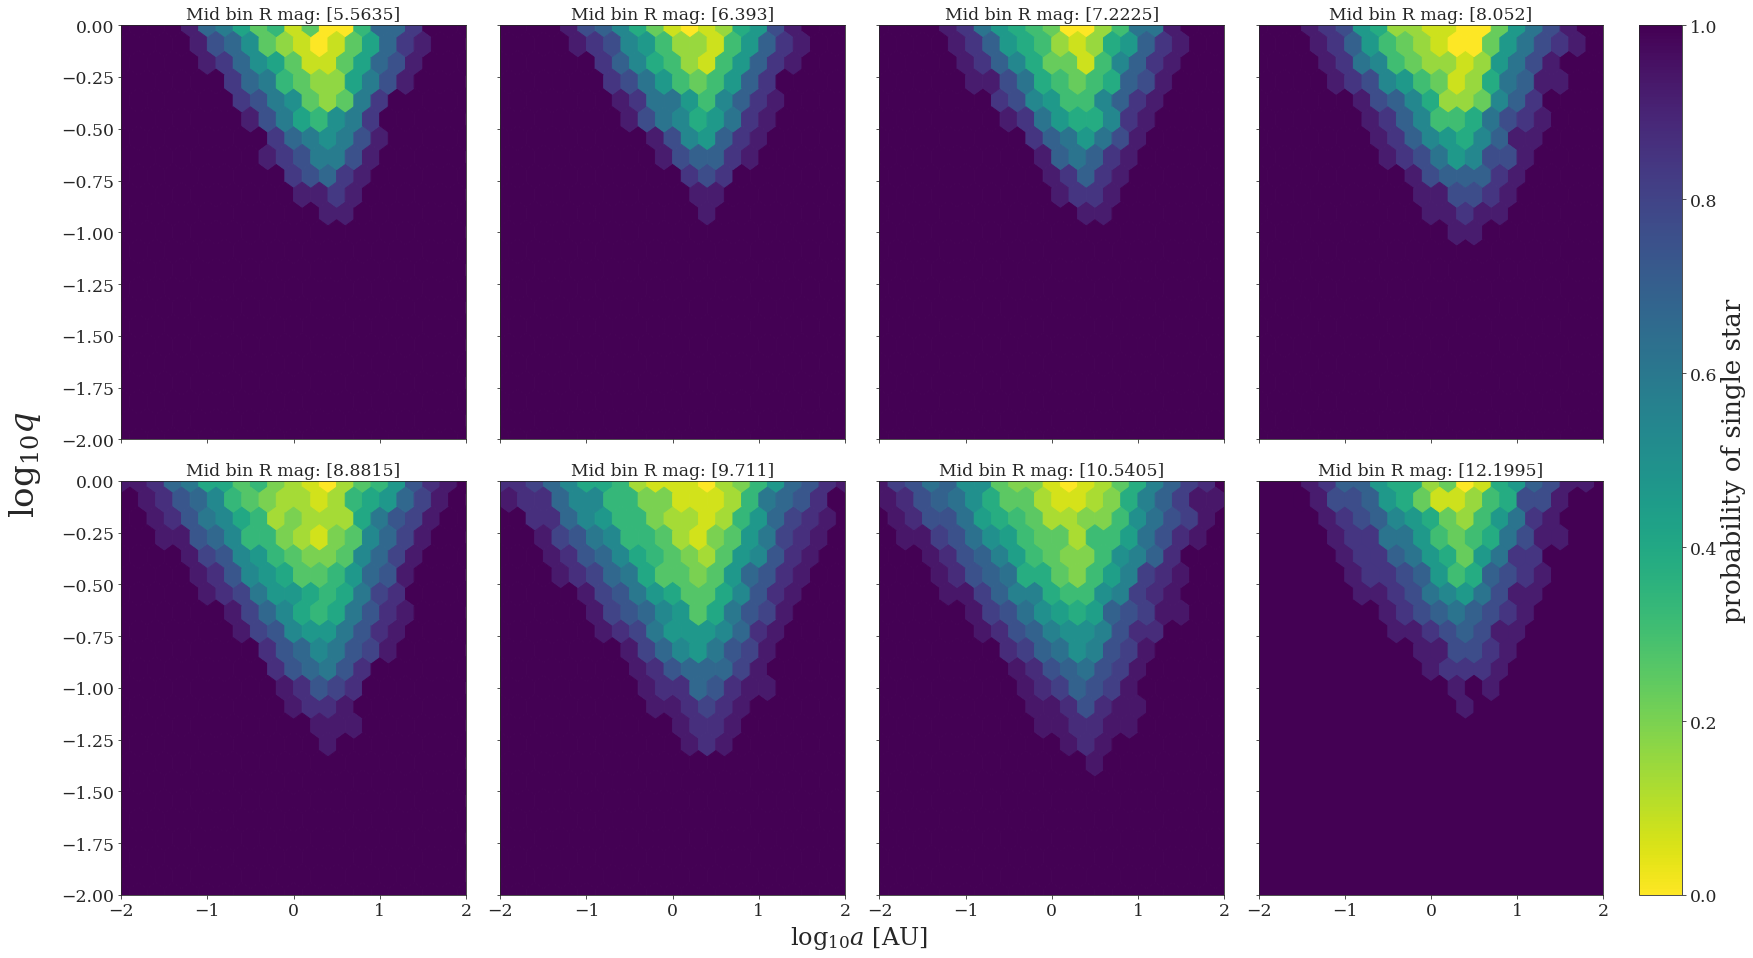

In [44]:
import matplotlib as mpl
counts = -1
colors = []
fig, axs = plt.subplots(2, 4,sharey=True, sharex=True,gridspec_kw={'wspace':0.1, 'hspace':0.1}, figsize=(32,16))
axs = axs.flatten()
for i in np.sort(binaries['mags'].unique()):
    if counts<7:
        counts=counts+1
    

    ax = axs[counts]
    plot_utils.hex_hist(np.log10(binaries['a'][binaries['mags']==i].astype(float)), np.log10(binaries['q'][binaries['mags']==i]),  ax, 20,'viridis_r',Z=(binaries['rv_p'][binaries['mags']==i]))
    title = binaries['mag bins'][binaries['mags']==i].unique()

    title = 'Mid bin R mag: '+ str(binaries['mags'][binaries['mags']==i].unique())

    ax.set_title(f'{title}')
    
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,0)
cmap = plt.get_cmap('viridis_r')   
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#axs[7].set_ylabel('$\log{q}$')
#axs[8].set_xlabel('$\log{a}$')
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(),aspect=20,pad=.02)

cbar.set_label('probability of single star',fontsize=26)
plot_utils.suplabel('y', '$\log_{10}{q}$ ',labelpad=3)
plt.suptitle('$\log_{10}{a}$ [AU]',x=.445,y=.10, va='top',fontsize=24)
plt.savefig('mean_single_probability.png', dpi=400,bbox_inches='tight')

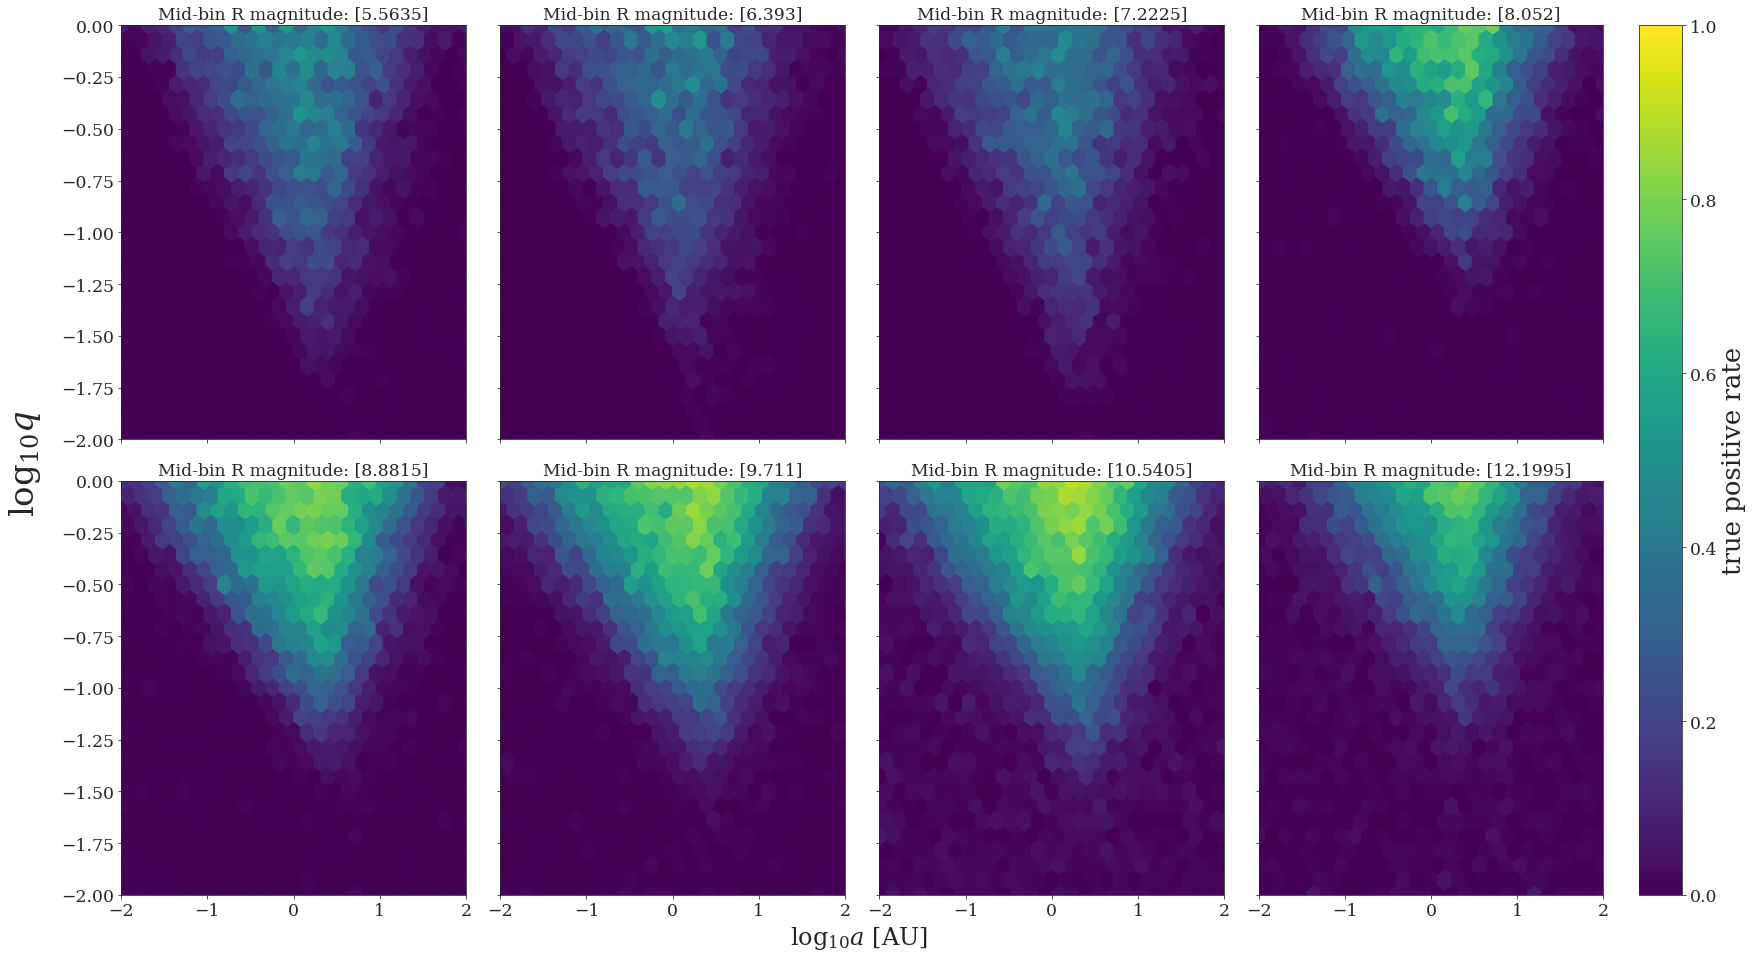

In [45]:
counts = -1
colors = []
fig, axs = plt.subplots(2, 4,sharey=True, sharex=True,gridspec_kw={'wspace':0.1, 'hspace':0.1}, figsize=(32,16))
axs = axs.flatten()
for i in np.sort(binaries['mags'].unique()):
    #fig = plt.figure(figsize=(12, 12))
    left, width = 0.075, 0.65
    bottom, height = 0.075, 0.65
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]
    x=binaries
    if counts<7:
        counts=counts+1
    #ax = fig.add_axes(rect_scatter)
    #print(axs)
    #for ax in axs:
    hb = axs[counts].hexbin(np.log10(x['a'][x['mags']==i][x['rv_p']<.9].astype(float)),np.log10(x['q'][x['mags']==i][x['rv_p']<.9]), gridsize=25)
    axs[counts].cla()
    hx=axs[counts].hexbin(np.log10(x['a'][x['mags']==i].astype(float)),np.log10(x['q'][x['mags']==i]), gridsize=25)
    axs[counts].cla()
    Z=hb.get_array()/hx.get_array()
    
    hf = axs[counts].hexbin(np.log10(x['a'][x['mags']==i].astype(float)),np.log10(x['q'][x['mags']==i]), cmap='viridis', vmin=0, vmax=1, gridsize=25)
    hf.set_array(Z)
    #cb = plt.colorbar()
    #cb.set_label('true positive rate',)
    #print(Z)
    title = 'Mid-bin R magnitude: '+ str(x['mags'][x['mags']==i].unique())
    #axs[counts].set_ylabel('$\log{q}$')
    #axs[counts].set_xlabel('$\log{a}$')
    axs[counts].set_xlim(-2,2)
    axs[counts].set_ylim(-2,0)
    axs[counts].set_title(title)
cmap = plt.get_cmap('viridis')   
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#axs[7].set_ylabel('$\log{q}$')
#axs[8].set_xlabel('$\log{a}$')
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(),aspect=20,pad=.02)

cbar.set_label('true positive rate',fontsize=26)
plot_utils.suplabel('y', '$\log_{10}{q}$',labelpad=3)
plt.suptitle('$\log_{10}{a}$ [AU]',x=.445,y=.10, va='top',fontsize=24)
plt.savefig('true_positive_rate.png', dpi=400,bbox_inches='tight')